In [1]:
import sys 
sys.path.append('../../')
sys.path.append('../../../')
from core.run_lib import * 
from core.passive_learning import * 
conf = OmegaConf.load('../../../configs/test/temp_conf.yaml')
#run_conf(conf)

In [2]:

logger   = get_logger('../../../temp/logs/act_lbl_test.log',stdout_redirect=True,level=logging.DEBUG)

set_seed(conf['random_seed'])

dm = DataManager(conf,logger)
len(dm.ds_std_train), len(dm.ds_std_val)

act_lbl = ActiveLabeling(conf,dm,logger)

act_lbl.init()

lst_epoch_out = act_lbl.run_al_loop()

logger.info('AL Loop Done')
#test_err = al.get_test_error(al.cur_clf,test_set,conf['inference_conf'])
out =  dm.get_auto_labeling_counts()


[09/05/2023 12:03:27 AM : DEBUG : data_manag : ] : (6000, 30)
[09/05/2023 12:03:27 AM : INFO  : data_manag : ] : Loaded dataset unif_unit_ball
[09/05/2023 12:03:27 AM : INFO  : data_manag : ] : Std train size: 6000 and Std. Val. Size:4000
[09/05/2023 12:03:27 AM : DEBUG : active_lab : ] : Unlabeled count in check_stop_criterion 6000
[09/05/2023 12:03:27 AM : DEBUG : active_lab : ] : cur_query_count= 0 and max_query_count=500
[09/05/2023 12:03:27 AM : INFO  : active_lab : ] : ===========================================================================
[09/05/2023 12:03:27 AM : DEBUG : active_lab : ] : ========================= BEGIN EPOCH 0 ============================
[09/05/2023 12:03:27 AM : DEBUG : active_lab : ] : Number of unalabeled points  :6000
[09/05/2023 12:03:27 AM : INFO  : active_lab : ] : Querying first batches of training and validation samples.
[09/05/2023 12:03:27 AM : DEBUG : active_lab : ] : Querying 100 seed training points
[09/05/2023 12:03:27 AM : DEBUG : active_la

KeyboardInterrupt: 

In [2]:
conf['train_pts_query_conf']['seed_train_size']= 10 
conf['train_pts_query_conf']['max_num_train_pts']= 50

conf['training_conf']['train_err_tol'] = -1
conf['training_conf']['max_epochs'] = 50
conf['training_conf']['weight_decay'] = 0.0
conf['training_conf']['learning_rate'] = 1.0
conf['training_conf']['use_lr_schedule'] = False 
conf['training_conf']['optimizer_name'] = 'sgd'
conf['training_conf']['batch_size'] = 32
conf['training_conf']['momentum'] = 0.9
conf['training_conf']['log_batch_loss_freq']=-1

In [4]:

logger   = get_logger('../../../temp/logs/act_lbl_test.log',stdout_redirect=True,level=logging.DEBUG)

set_seed(conf['random_seed'])

dm = DataManager(conf,logger)
len(dm.ds_std_train), len(dm.ds_std_val)


pl = PassiveLearning(conf,dm,logger)

out = pl.run()

w = pl.cur_clf.get_weights()
print(torch.norm(w))
test_err = get_test_error(pl.cur_clf,dm.ds_std_test,conf['inference_conf'])
print(test_err)

[09/05/2023 12:07:55 AM : DEBUG : data_manag : ] : (6000, 30)
[09/05/2023 12:07:55 AM : INFO  : data_manag : ] : Loaded dataset unif_unit_ball
[09/05/2023 12:07:55 AM : INFO  : data_manag : ] : Std train size: 6000 and Std. Val. Size:4000
[09/05/2023 12:07:55 AM : DEBUG : passive_le : ] : Querying 10 seed training points
[09/05/2023 12:07:55 AM : DEBUG : passive_le : ] : Queried 10 seed points for training
[09/05/2023 12:07:55 AM : DEBUG : passive_le : ] : Validation Data Size :1000
[09/05/2023 12:07:55 AM : DEBUG : passive_le : ] : Querying rest of the training points 40 in single batch
[09/05/2023 12:07:55 AM : INFO  : passive_le : ] : Labeled data size for training: 50
[09/05/2023 12:07:55 AM : INFO  : pytorch_cl : ] : {'model_name': 'binary_logistic_regression', 'input_dimension': 30, 'num_classes': 2, 'fit_intercept': False, 'lib': 'pytorch'}
[09/05/2023 12:07:55 AM : INFO  : passive_le : ] : --------------- Begin Model Training ------------
[09/05/2023 12:07:55 AM : INFO  : passi

0.11834545367956159


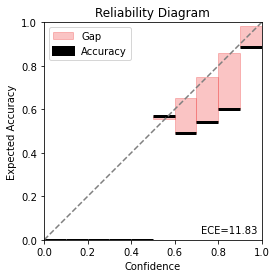

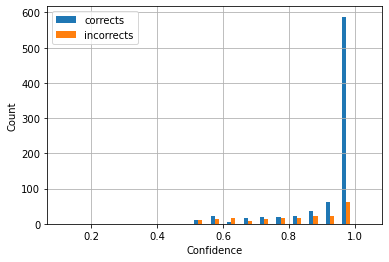

In [5]:
cur_val_ds,cur_val_idcs=dm.get_current_validation_data()

val_set_subset = cur_val_ds

val_inf_out = pl.cur_clf.predict(val_set_subset,conf['inference_conf'])
cal_out = compute_calibration(val_set_subset.Y.numpy(), val_inf_out['labels'].numpy(), val_inf_out['confidence'].numpy(), num_bins=10)
print(cal_out['expected_calibration_error'])
ax = plt.subplot(111)
reliability_diagram_subplot(ax,cal_out)

plt.figure() 
o = val_inf_out

m = len(o['confidence'])
S = np.zeros((m,4))
S[:,0] = o['confidence']
S[:,1] = o['labels'] 
S[:,2] = val_set_subset.Y
S[:,3] = S[:,1]==S[:,2]

S = S[(-S[:,0]).argsort()]
 
bins = np.arange(0.1,1.1,0.05)
labels = ['corrects','incorrects']
plt.hist([S[S[:,3]==1,0],S[S[:,3]==0,0]],bins=bins,rwidth=0.5, histtype ='bar',label=labels)
plt.legend()
plt.ylabel('Count')
plt.xlabel('Confidence')
plt.grid() 


In [10]:
from calibration.calibrators import * 

conf['calibrate_clf'] = True 
calib_train_conf = {} 

calib_train_conf['optimizer']='lbfgs'
calib_train_conf['learning_rate']= 1.0

calib_train_conf['batch_size']= 64 #len(train_set)
calib_train_conf['shuffle']= True
calib_train_conf['max_epochs'] = 20
calib_train_conf['normalize_weights']=False

calib_train_conf['log_train_ece'] = True 
calib_train_conf['log_train_ece_freq']= 1
calib_conf = {'name':'temperature_scaling'}

calib_conf['training_conf'] = calib_train_conf

conf['calibration_conf'] = calib_conf 

val_set_subset = cur_val_ds

inf_out = pl.cur_clf.predict(val_set_subset,conf['inference_conf'])


logger = get_logger('../../../temp/logs/pl2.log','PL2',level=logging.DEBUG)
calib= TemperatureScalingCalibrator(clf=pl.cur_clf,calib_conf=calib_conf,logger=logger)
calib.fit(val_set_subset)

[09/05/2023 12:12:43 AM : INFO  : pytorch_cl : ] : {'model_name': 'temp_scaling'}
[09/05/2023 12:12:43 AM : INFO  : pytorch_cl : ] : {'model_name': 'temp_scaling'}
[09/05/2023 12:12:43 AM : INFO  : pytorch_cl : ] : {'model_name': 'temp_scaling'}
[09/05/2023 12:12:43 AM : INFO  : pytorch_cl : ] : {'model_name': 'temp_scaling'}
[09/05/2023 12:12:43 AM : INFO  : pytorch_cl : ] : {'model_name': 'temp_scaling'}
[09/05/2023 12:12:43 AM : DEBUG : model_trai : ] : Training conf : {'optimizer': 'lbfgs', 'learning_rate': 1.0, 'batch_size': 64, 'shuffle': True, 'max_epochs': 20, 'normalize_weights': False, 'log_train_ece': True, 'log_train_ece_freq': 1, 'loss_function': 'std_cross_entropy', 'weight_decay': 0.0001, 'momentum': 0.9, 'optimizer_name': 'sgd', 'loss_tol': 1e-06, 'max_max_epochs': 10000, 'device': 'cpu', 'stopping_criterion': 'max_epochs', 'log_val_err': False, 'log_val_ece': False, 'use_lr_schedule': True, 'train_err_tol': 0.001, 'log_batch_loss_freq': 20, 'log_val_err_freq': 5, 'log_

In [ ]:
logger.disabled=False

0.023677184045314784


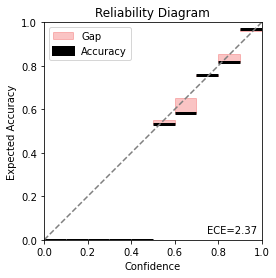

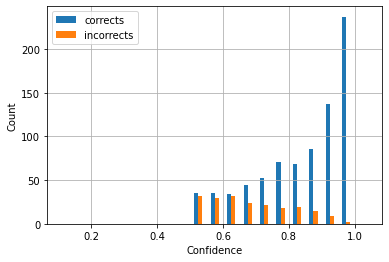

In [11]:
val_set_subset = cur_val_ds
val_inf_out = calib.predict(val_set_subset,conf['inference_conf'])
cal_out = compute_calibration(val_set_subset.Y.numpy(), val_inf_out['labels'].numpy(), val_inf_out['confidence'].numpy(), num_bins=10)
print(cal_out['expected_calibration_error'])
ax = plt.subplot(111)
reliability_diagram_subplot(ax,cal_out)

plt.figure() 
o = val_inf_out

m = len(o['confidence'])
S = np.zeros((m,4))
S[:,0] = o['confidence']
S[:,1] = o['labels'] 
S[:,2] = val_set_subset.Y
S[:,3] = S[:,1]==S[:,2]

S = S[(-S[:,0]).argsort()]
 
bins = np.arange(0.1,1.1,0.05)
labels = ['corrects','incorrects']
plt.hist([S[S[:,3]==1,0],S[S[:,3]==0,0]],bins=bins,rwidth=0.5, histtype ='bar',label=labels)
plt.legend()
plt.ylabel('Count')
plt.xlabel('Confidence')
plt.grid() 
